In [1]:
#IMPORTS
import numpy as np
import pandas as pd
import sklearn.linear_model as skl
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from sklearn.linear_model import LinearRegression
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import KFold
import matplotlib.pyplot as plt

In [3]:
#Data set1
data_1 = pd.read_csv('dataset1.csv')
Y1 = data_1['target']
X1 = data_1.drop(['target'], axis=1)
n,d=X1.shape
X1s=(X1 - X1.mean()) / X1.std()

In [5]:
#Data set2
data_2 = pd.read_csv('dataset2.csv')
Y2 = data_2['target']
X2 = data_2.drop(['target'], axis=1)
n,d=X2.shape
X2s=(X2 - X2.mean()) / X2.std()

In [7]:
#Data set3
data_3 = pd.read_csv('dataset3.csv')
Y3 = data_3['target']
X3 = data_3.drop(['target'], axis=1)
n,d=X3.shape
X3s=(X3 - X3.mean()) / X3.std()

In [9]:
#Data set4
data_4 = pd.read_csv('dataset4.csv')
Y4 = data_4['target']
X4 = data_4.drop(['target'], axis=1)
n,d=X4.shape
X4s=(X4 - X4.mean()) / X4.std()

In [11]:
#Data set5
data_5 = pd.read_csv('dataset5.csv')
Y5 = data_5['target']
X5 = data_5.drop(['target'], axis=1)
n,d=X5.shape
X5s=(X5 - X5.mean()) / X5.std()

In [13]:
#LASSO returning the coefficients in the list(beta0, beta1, beta2,..) or prediction and taking in the data
def Lasso_Regression(X, Y, tuning_param, X_test=None):
    Xs = (X - X.mean()) / X.std()
    lasso = skl.ElasticNet(l1_ratio=1, alpha=tuning_param)
    model = lasso.fit(Xs, Y)
    coefficients = model.coef_.tolist()
    coefficients.insert(0, model.intercept_)  # Modify in place
    if X_test is not None:
        X_tests = (X_test - X.mean()) / X.std()
        Y_pred = lasso.predict(X_tests)
        return Y_pred
    return coefficients

In [15]:
#FORWARD STEPWISE returning the coefficients in the list(beta0, beta1, beta2,..) or prediction and taking in the data
def Forward_Stepwise_Selection(X, Y, num_feat, X_test=None):
    lr = LinearRegression()
    sfs = SFS(lr, k_features=num_feat, forward=True, floating=False, scoring='neg_mean_squared_error', cv=0)
    forward = sfs.fit(X, Y)
    selected_features_indices = list(sfs.k_feature_idx_)
    X_selected = X.iloc[:, selected_features_indices]
    lr.fit(X_selected, Y)
    coefficients = lr.coef_.tolist()
    intercept = lr.intercept_
    coefficients.insert(0, intercept)
    if X_test is not None:
        X_test_selected = X_test.iloc[:, selected_features_indices]
        Y_pred = lr.predict(X_test_selected)
        return Y_pred
    return coefficients

In [17]:
#PCA returning the coefficients in the list(beta0, beta1, beta2,..) or prediction and taking in the data
def PCAc(X, Y, n_components, X_test=None):
    scaler = StandardScaler(with_mean=True,  with_std=True)
    pca = PCA(n_components=n_components)
    linreg = skl.LinearRegression()
    pipe = Pipeline([('scaler', scaler), 
                     ('pca', pca),
                     ('linreg', linreg)])
    pipe.fit(X, Y)
    not0coeff = pipe.named_steps['linreg'].coef_.tolist()
    coeff = [0] + not0coeff
    if X_test is not None:
        Y_pred = pipe.predict(X_test)
        return Y_pred
    return coeff

In [19]:
def Ridge_Regression(X, Y, tuning_param, X_test=None):
    scaler = StandardScaler(with_mean=True,  with_std=True)
    Xs = scaler.fit_transform(X)
    ridge = skl.ElasticNet(l1_ratio=0, alpha=tuning_param)
    ridge.fit(Xs, Y)
    coefficients = ridge.coef_.tolist()
    intercept = ridge.intercept_
    coefficients.insert(0, intercept)
    if X_test is not None:
        X_test_scaled = scaler.transform(X_test)  # Standardize test data
        Y_pred = ridge.predict(X_test_scaled)
        return Y_pred
    return coefficients

In [21]:
def k_fold_split(X, Y, k):
    n = X.shape[0]
    kf = KFold(n_splits=k, shuffle=False)
    for train_indices, val_indices in kf.split(range(n)):
        # Handle NumPy arrays or Pandas DataFrames appropriately
        if isinstance(X, pd.DataFrame):
            X_train, X_val = X.iloc[train_indices], X.iloc[val_indices]
            Y_train, Y_val = Y.iloc[train_indices], Y.iloc[val_indices]
        else:  # Assume NumPy array
            X_train, X_val = X[train_indices], X[val_indices]
            Y_train, Y_val = Y[train_indices], Y[val_indices]
        yield X_train, X_val, Y_train, Y_val

In [23]:
#Fuction estimating test MSE, using CV_MSE for any function (any of the 4 methods)
def CV_score(X, Y, function, tuning_param, num_folds):
    MSE=[]
    n = X.shape[0]
    for fold, (x_train, x_val, y_train, y_val) in enumerate(k_fold_split(X, Y, num_folds), start=1):
        predictions_of_y_val = function(x_train, y_train, tuning_param, X_test=x_val)
        predictions_of_y_val = np.array(predictions_of_y_val, dtype=float)
        y_val = np.array(y_val, dtype=float)
        squared_errors = (predictions_of_y_val - y_val)**2
        MSE.append(sum(squared_errors)/len(y_val))
    CV_MSE=np.mean(MSE)
    print(f"CVMSE of {num_folds} for {function}: {CV_MSE}")
    return CV_MSE

In [25]:
def CV_MSE_comparsion(X, Y, forward_tuning, ridge_tuning, lasso_tuning, pca_tuning):
    num_folds_space = np.linspace(2, 100, num=5, dtype=int)
    forward_CV_MSE = []
    ridge_CV_MSE = []
    lasso_CV_MSE = []
    pca_CV_MSE = []

    for num_folds in num_folds_space:
        forward_CV_MSE.append(CV_score(X, Y, Forward_Stepwise_Selection, forward_tuning, num_folds))
        ridge_CV_MSE.append(CV_score(X, Y, Ridge_Regression, ridge_tuning, num_folds))
        lasso_CV_MSE.append(CV_score(X, Y, Lasso_Regression, lasso_tuning, num_folds))
        pca_CV_MSE.append(CV_score(X, Y, PCAc, pca_tuning, num_folds))

    # Debugging: Ensure numeric values and matched sizes
    print("Debugging Data Sizes:")
    print(f"num_folds_space: {len(num_folds_space)}")
    print(f"Forward CV MSE: {len(forward_CV_MSE)}")
    print(f"Ridge CV MSE: {len(ridge_CV_MSE)}")
    print(f"Lasso CV MSE: {len(lasso_CV_MSE)}")
    print(f"PCA CV MSE: {len(pca_CV_MSE)}")

    # Plotting
    plt.plot(num_folds_space, forward_CV_MSE, label='Forward Stepwise', marker='o')
    plt.plot(num_folds_space, ridge_CV_MSE, label='Ridge Regression', marker='s')
    plt.plot(num_folds_space, lasso_CV_MSE, label='Lasso Regression', marker='^')
    plt.plot(num_folds_space, pca_CV_MSE, label='PCA', marker='x')
    plt.title("Cross-Validation MSE vs. Number of Folds")
    plt.xlabel("Number of Folds")
    plt.ylabel("CV MSE")
    plt.legend()
    plt.grid(True)
    plt.show()


In [ ]:
#dont run it yourself
CV_MSE_comparsion(X1,Y1,4,0.02535364494,0.0486260158,7)

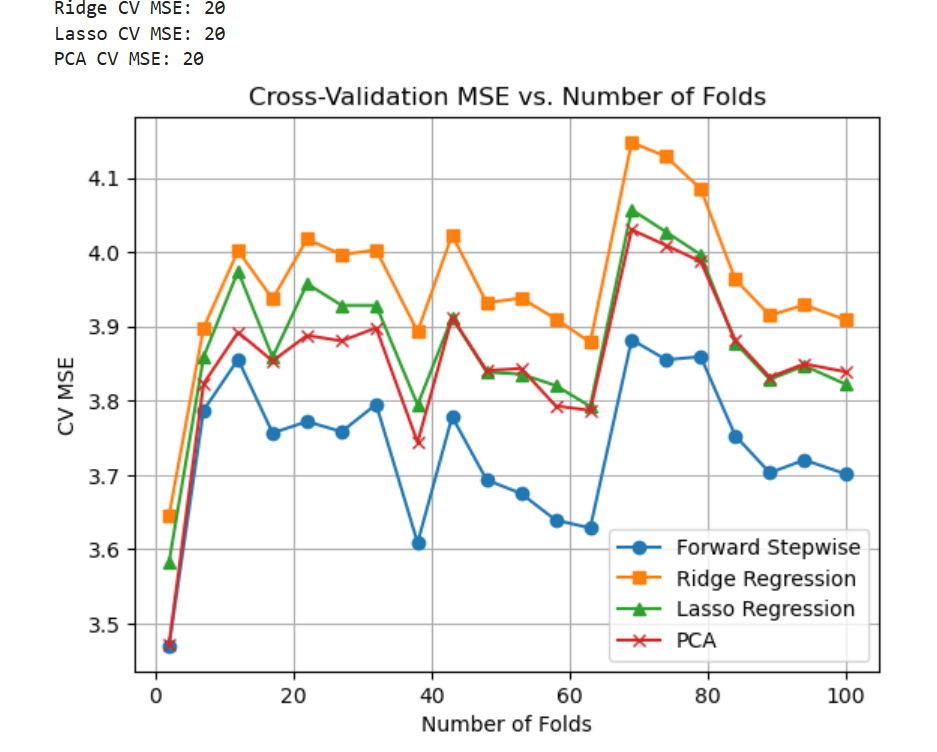

In [31]:
from IPython import display
display.Image("dataset1-20folds.png")

In [ ]:
#dont run it yourself!!!
CV_MSE_comparsion(X2,Y2,6,9.770099573,0.312571585,3)

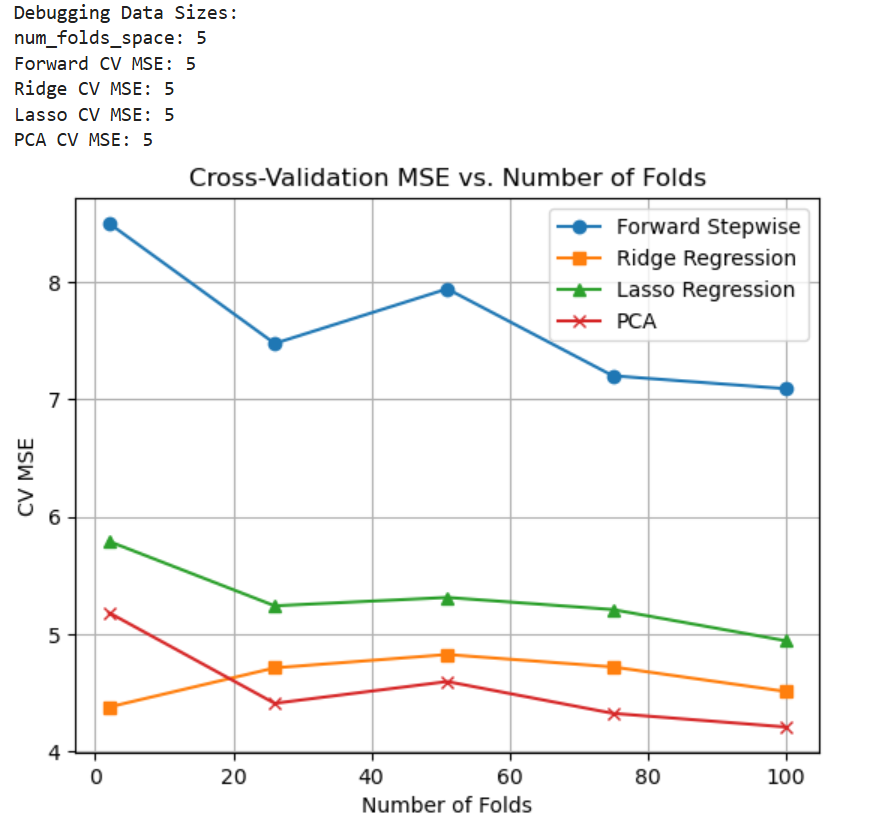

In [35]:
from IPython import display
display.Image("Zrzut ekranu 2025-01-18 185401.png")

In [ ]:
#dont run it yourself
CV_MSE_comparsion(X3,Y3,2,5.094138015,0.41320124,6)

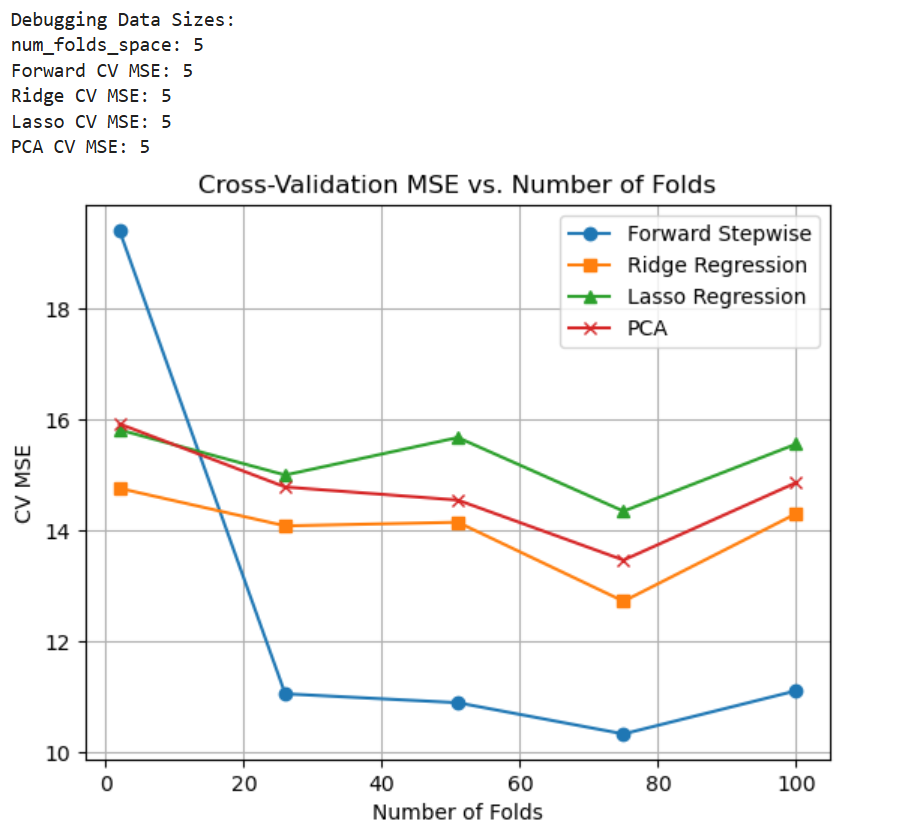

In [37]:
display.Image("Zrzut ekranu 2025-01-18 192302.png")

In [ ]:
#dont run it yourself
CV_MSE_comparsion(X4,Y4,4,5.094138015,0.196304065,10)

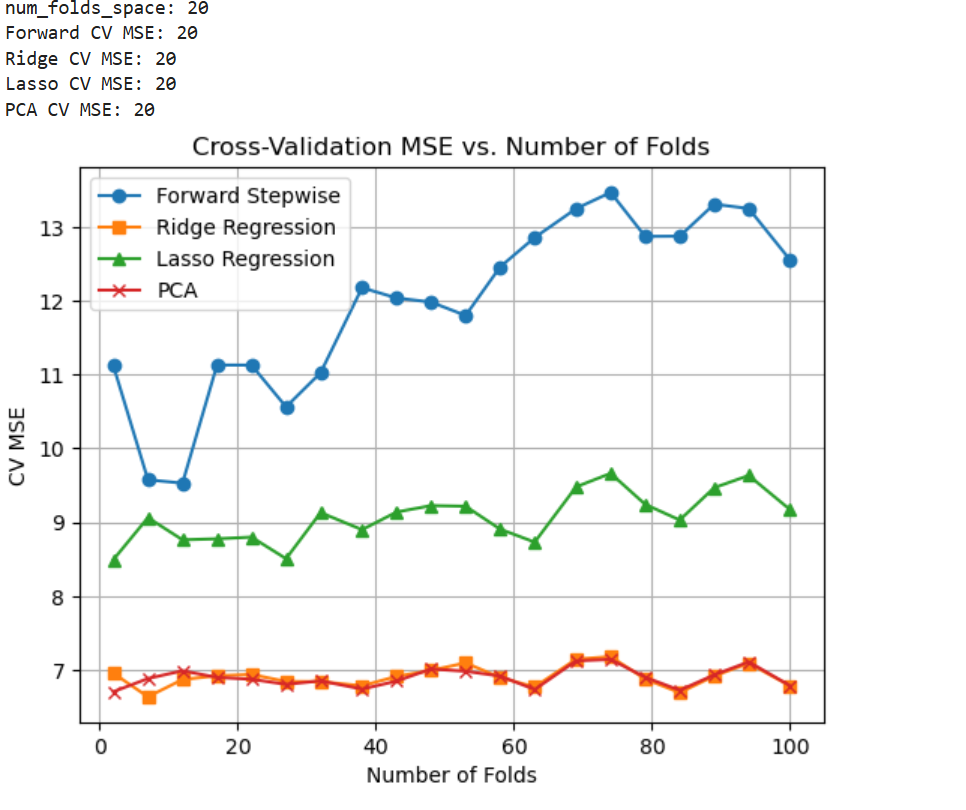

In [39]:
display.Image("dataset4-20folds.png")

In [ ]:
CV_MSE_comparsion(X5,Y5,8,0.2848035868,0.196304065,8)

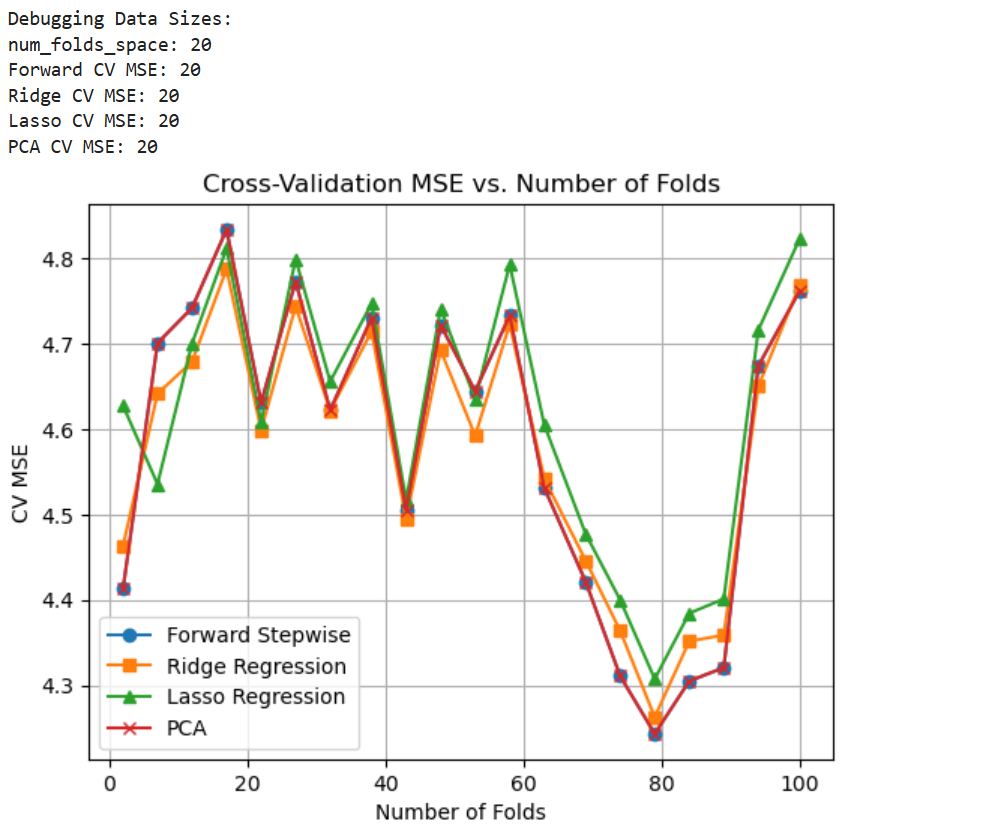

In [41]:
display.Image("dataset5-20folds.png")